## AUTO1 Challenge

> Please take a look at the following dataset and answer the following questions:
https://archive.ics.uci.edu/ml/datasets/Automobile

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data/imports-85.data', header=None, na_values='?')
data.columns = ['symboling', 
    'normalized-losses', 
    'make', 
    'fuel-type', 
    'aspiration', 
    'num-of-doors', 
    'body-style', 
    'drive-wheels', 
    'engine-location', 
    'wheel-base', 
    'length', 
    'width', 
    'height', 
    'curb-weight', 
    'engine-type', 
    'num-of-cylinders', 
    'engine-size', 
    'fuel-system', 
    'bore', 
    'stroke', 
    'compression-ratio', 
    'horsepower',
    'peak-rpm',
    'city-mpg',
    'highway-mpg',
    'price']
data.head().T

,0,1,2,3,4
symboling,3,3,1,2,2
normalized-losses,NaN,NaN,NaN,164,164
make,alfa-romero,alfa-romero,alfa-romero,audi,audi
fuel-type,gas,gas,gas,gas,gas
aspiration,std,std,std,std,std
num-of-doors,two,two,two,four,four
body-style,convertible,convertible,hatchback,sedan,sedan
drive-wheels,rwd,rwd,rwd,fwd,4wd
engine-location,front,front,front,front,front
wheel-base,88.6,88.6,94.5,99.8,99.4


### Question 1 (10 Points)

> List as many use cases for the dataset as possible.

- predicting price
- predicting length, width, height, curb-weight, bore, and other stuff that can owners might not know


### Question 2 (10 Points)

> Auto1 has a similar dataset (yet much larger...). 
> Pick one of the use cases you listed in question 1 and describe how building a statistical model based on the dataset could best be used to improve Auto1's business.

Let's implement the price model. Such a model could be used to give an estimate of the price that AUTO1 should use


### Question 3 (10 Points)

> Implement the model you described in question 2 in R or Python. The code has to retrieve the
data, train and test a statistical model, and report relevant performance criteria.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
data.shape

(205, 26)

We don't have a lot of data, so the model should be very simple

In [5]:
data.price.isnull().sum()

4

There are some missing value for the price attribute, but since we are predicting price, we can drop the rows where it's missing

In [6]:
data = data[~data.price.isnull()]

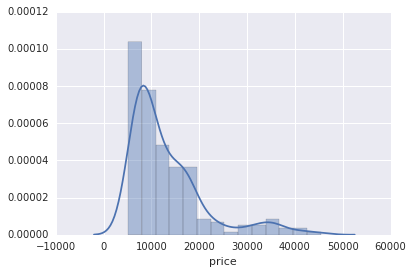

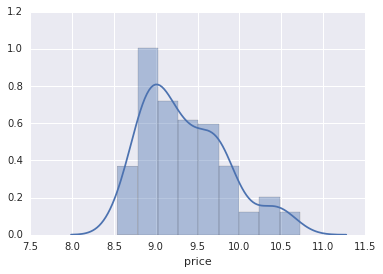

In [7]:
sns.distplot(data.price)
plt.show()
sns.distplot(np.log(data.price))
plt.show()

It makes more sense to predict the log of price instead of price. In this case the evaluation metric RMSE becomes RMSLE, which tells us the order of mistake, not its absolute value - which is good for prices, especially big ones. 

Now let's create a model. First, we hold out some data to be used for testing

In [8]:
from sklearn.cross_validation import train_test_split
df_train, df_test = train_test_split(data, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=1)
df_test =  df_test.reset_index(drop=1)

First, let us deal with missing values. Let's use simplest approach: imputing with median 

In [9]:
numerical = [
    'symboling',
    'normalized-losses',
    'wheel-base',
    'length',
    'width',
    'height',
    'curb-weight',
    'engine-size',
    'bore',
    'stroke',
    'compression-ratio',
    'horsepower',
    'peak-rpm',
    'city-mpg',
    'highway-mpg',
]

In [10]:
nulls_columns = df_train[numerical].isnull().sum()
nulls_columns = list(nulls_columns[nulls_columns > 0].index)
nulls_columns

['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm']

In [11]:
for col_name in nulls_columns:
    median = df_train[col_name].median()

    nulls = df_train[col_name].isnull()
    df_train.loc[nulls, col_name] = median
    
    nulls = df_test[col_name].isnull()
    df_test.loc[nulls, col_name] = median

Then we will need some standardization: to help the model converge and to be able to use regularization

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()

num_train = scaler.fit_transform(df_train[numerical].values)
num_test =  scaler.transform(df_test[numerical].values)

Now encode categorical variables via One-Hot-Econding

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
categorical = [
    'make',
    'fuel-type',
    'aspiration',
    'num-of-doors',
    'body-style',
    'drive-wheels',
    'engine-location',
    'engine-type',
    'num-of-cylinders',
]

In [16]:
def join_dict(d):
    return ' '.join('%s=%s' % (k, v.replace(' ', '_')) for (k, v) in d.items() if v)

dicts_train = df_train[categorical].fillna('').to_dict(orient='records')
dicts_train = [join_dict(d) for d in dicts_train]

dicts_test = df_test[categorical].fillna('').to_dict(orient='records')
dicts_test = [join_dict(d) for d in dicts_test]

In [17]:
cv = CountVectorizer(analyzer=str.split, min_df=5, dtype='uint8')
cat_train = cv.fit_transform(dicts_train)
cat_test = cv.transform(dicts_test)

Now let's create a model. We will use OLS and LASSO. To evaluate the model we'll use RMSLE

In [18]:
y_train = np.log(df_train.price.values)
y_test = np.log(df_test.price.values)

X_train = np.hstack([num_train, cat_train.toarray()])
X_test = np.hstack([num_test, cat_test.toarray()])

In [19]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

In [20]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [21]:
ols = LinearRegression()
ols.fit(X_train, y_train)

y_pred = ols.predict(X_test)
rmse(y_test, y_pred)

0.1502901644698745

The value of RMSLE=0.15 means that on average we are wrong on 0.15 orders of magniture

Let's try LASSO

In [22]:
lasso = Lasso(alpha=0.001, random_state=1)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
rmse(y_test, y_pred)

0.13867348321109663

LASSO with $\alpha=0.001$ is slightly better than OLS

Bonus: let's have a look at weights of the model:

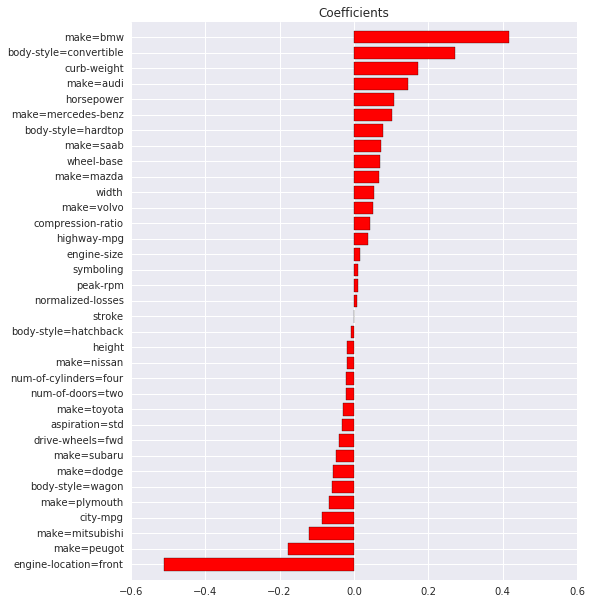

In [27]:
features = np.array(numerical + cv.get_feature_names())
coef = lasso.coef_
features = features[coef != 0.0]
coef = coef[coef != 0]
coef_idx = np.argsort(coef)

plt.figure(figsize=(8, 10))
plt.title("Coefficients")
coef_num = range(len(coef))
plt.barh(coef_num, coef[coef_idx], color="r", align="center")

plt.yticks(coef_num, features[coef_idx])
plt.ylim([-1, len(features)])

plt.show()

So, `make=bmw` and `body-style=convertible` contribute most to high prices, while `make=peugot` and `engine-location=front` contribute most to low prices

### Question 4 (70 Points)

> A. Explain each and every of your design choices (e.g., preprocessing, model selection, hyper
parameters, evaluation criteria). Compare and contrast your choices with alternative
methodologies.

- preprocessing: 
    - imputation with medians, because it's simple to implement and often works well in practice. alternatives: dropping the values, imputing with models
    - one hot encoding for categorical variables. alternatives: mean target value
- model selection
    - I tried only very simple models because the dataset is small
    - I selected the model based on the test error
- hyper parameters
    - I (almost) did not tune any parameters. The proper approach would be to do it via taking a part of the traning set as a valiation set and use it for tuning the parameters, or doing k-fold CV
- evaluation criteria
    - I used RMSLE because it's often used when dealing with prices: it penalizes more the mistakes for low prices and less for high prices. Alternatives are other evaluation metrics for regression such as RMSE, MAE and others


> B. Describe how you would improve the model in Question 3 if you had more time.

- More feature engineering
    - Right now I use features almost as is, but it is possible to derive mode features from the existing ones. 
    - For example, feature interactions like length $\times$ width $\times$ height or make $\times$ body-style
- Proper CV 
    - Here I use only the held out dataset for model evaluation AND model selection. In this case I only compared two models, so it is OK. However, if there are more models and some of them need parameter tuning, a proper Cross-Validation framework is needed. Something like K-fold on the train data should be enough 
- Better handling of missing values. E.g. with models
- More models 
    - SVR 
    - Tree based like Random Forest or GBM - but I'd need to be careful with these, because there is little data, so they could easily overfit


You can see more examples of my code at my github account at https://github.com/alexeygrigorev